## <font color=red>This notebook is in preliminary stages and needs work! </font>

<div>
<img src="images/icon_important.jpg" width="50" align="left"/>
</div>
<br>
<br>

#### __Important Legal Notice__
By running and editing this Jupyter notebook with the corresponding dataset, you agree that you will not use or store the data for other purposes than participating in the Champagne Coding with DNB & Women in Data Science, Oslo. You will delete the data and notebook after the event and will not attempt to identify any of the commentors.

### Evaluating mobile app reviews

Here we will evaluate the mobile app reviews we scraped in the first notebook and:
- Analyse user sentiments using the comments and ratings
- Identify areas of interest among the reviews using topic modeling
- Explore and compare with other mobile app reviews

In [1]:
from pathlib import Path
current_directory = Path.cwd()
reviews_directory = Path(current_directory, 'reviews')

#### Let's start by reading in our reviews

In [2]:
import pandas as pd

df = pd.read_csv(Path(reviews_directory, 'dnb_reviews.csv'))

try:
    df = df.drop('Unnamed: 0', axis=1)
except:
    pass

df.head()

,Date,Name,Review_Score,Review_Text
0,"August 21, 2019",Daniel Kling,1,Complete trash. Used to be ok. Its hardly an a...
1,"August 21, 2019",Gatos delamuerte,4,"""SIM tool launches before the page is done loa..."
2,"August 21, 2019",Jens Powelson,4,Worst app ever? Slower and affords less privac...
3,"August 16, 2019",Stig Martinus Fromreide,3,I have been using the old and new version of t...
4,"August 21, 2019",Daniel Kling,1,Complete trash. Used to be ok. Its hardly an a...


#### Understanding our reviews

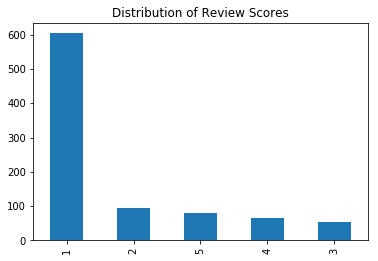

In [7]:
%matplotlib inline

df.Review_Score.value_counts().plot(kind='bar',
                                    figsize=(6,4),
                                    title="Distribution of Review Scores")

Ok, let's try to understand the breakdown of these scores and see if we see any trends.

In [4]:
df_review_scores_over_time = df.groupby(['Date','Review_Score']).size().unstack()

df_review_scores_over_time.index = pd.to_datetime(df_review_scores_over_time.index)
df_review_scores_over_time.sort_index(inplace = True)

df_review_scores_over_time = df_review_scores_over_time.fillna(0)

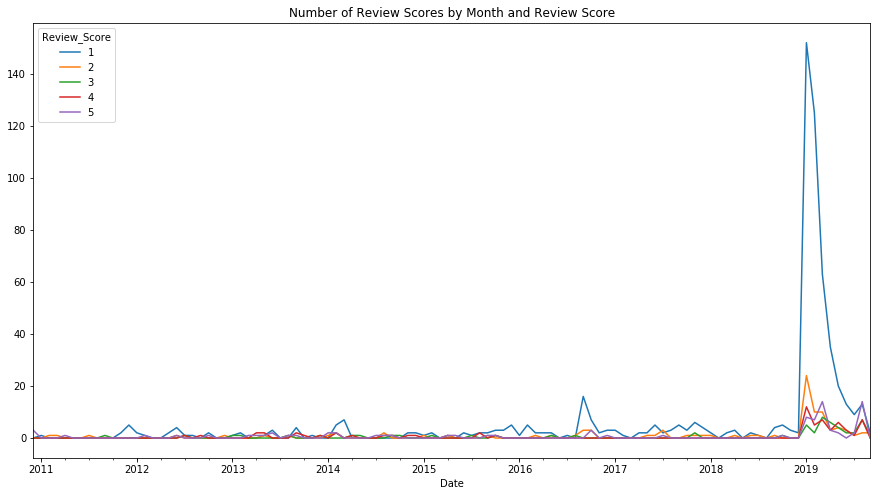

In [8]:
monthly = df_review_scores_over_time.groupby(pd.Grouper(freq="M")).sum()

monthly.plot(figsize=(15,8),
             title="Number of Review Scores by Month and Review Score")

We see a dramatic increase in the number of review scores and some peaks in the number of reviews with a rating og 1-2 over time. Let's see how this aligns with releases.

## <font color=red>Note to selves -- Do we have information about releases?</font>

#### Sentiment Analysis
Sentiment analysis is a set of Natural Language Processing (NLP) techniques that takes a text, or document, written in natural language and extracts the opinions present in the text.

In a more practical sense, our objective here is to take a text and produce a label (or labels) that summarizes the sentiment of this text, e.g. positive, neutral, and negative.

For example, if we were dealing with hotel reviews, we would want the sentence ‘The staff were lovely‘ to be labeled as Positive, and the sentence ‘The shared bathroom was absolutely disgusting‘ labeled as Negative. 

#### The process

<div>
<img style="float: right" 
     src="images/process.png" 
     width="200" />
    
<p> 

Before we can build our sentiment classifier, we need to go through a couple of steps to prepare our data for classification:
    <li>Tokenization</li>
    <li>Stop Word filtering</li>
    <li>Negation handling</li>
    <li>Stemming</li>
    <li>Classification </li>

</p> 
    
</div>
<br>




### Defining Positivity vs. Negativity

From a strict machine learning point of view, this is a _supervised learning_ task where we want to identify whether a text is positive or negative. This task can be binary - positive or negative - or multi-class.

In [ ]:
import nltk
import random
from nltk.classify.scikitlearn import SklearnClassifier
import pickle
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from nltk.classify import ClassifierI
from statistics import mode
from nltk.tokenize import word_tokenize
import re
import os

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

#### Predict positive vs negative OR predict review score?

## <font color=red> Code has been copied from the internet and needs to be adapted for our purposes </font>

In [ ]:
files_pos = os.listdir('aclImdb/train/pos')
files_pos = [open('aclImdb/train/pos/'+f, 'r').read() for f in files_pos]
files_neg = os.listdir('aclImdb/train/neg')
files_neg = [open('aclImdb/train/neg/'+f, 'r').read() for f in files_neg]


all_words = []
documents = []

from nltk.corpus import stopwords
import re

In [ ]:
stop_words = list(set(stopwords.words('english')))

#  j is adject, r is adverb, and v is verb
#allowed_word_types = ["J","R","V"]
allowed_word_types = ["J"]

for p in files_pos:
    
    # create a list of tuples where the first element of each tuple is a review
    # the second element is the label
    documents.append( (p, "pos") )
    
    # remove punctuations
    cleaned = re.sub(r'[^(a-zA-Z)\s]','', p)
    
    # tokenize 
    tokenized = word_tokenize(cleaned)
    
    # remove stopwords 
    stopped = [w for w in tokenized if not w in stop_words]
    
    # parts of speech tagging for each word 
    pos = nltk.pos_tag(stopped)
    
    # make a list of  all adjectives identified by the allowed word types list above
    for w in pos:
        if w[1][0] in allowed_word_types:
            all_words.append(w[0].lower())
    
    
for p in files_neg:
    # create a list of tuples where the first element of each tuple is a review
    # the second element is the label
    documents.append( (p, "neg") )
    
    # remove punctuations
    cleaned = re.sub(r'[^(a-zA-Z)\s]','', p)
    
    # tokenize 
    tokenized = word_tokenize(cleaned)
    
    # remove stopwords 
    stopped = [w for w in tokenized if not w in stop_words]
    
    # parts of speech tagging for each word 
    neg = nltk.pos_tag(stopped)
    
    # make a list of  all adjectives identified by the allowed word types list above
    for w in neg:
        if w[1][0] in allowed_word_types:
            all_words.append(w[0].lower())

In [ ]:
# creating a frequency distribution of each adjectives.
all_words = nltk.FreqDist(all_words)

# listing the 5000 most frequent words
word_features = list(all_words.keys())[:5000]

# function to create a dictionary of features for each review in the list document.
# The keys are the words in word_features 
# The values of each key are either true or false for wether that feature appears in the review or not

def find_features(document):
    words = word_tokenize(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)
    return features

# Creating features for each review
featuresets = [(find_features(rev), category) for (rev, category) in documents]

# Shuffling the documents 
random.shuffle(featuresets)

training_set = featuresets[:20000]
testing_set = featuresets[20000:]

In [ ]:
classifier = nltk.NaiveBayesClassifier.train(training_set)

print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, testing_set))*100)

classifier.show_most_informative_features(15)

### How does our classifier improve and change if we incorporate reviews from other applications?

### Topic Mining

#### How do topics vary by application and sentiment?

##### Among those who are most positive, what do they mention?

##### Among those who are most negative, what do they mention?